## Part II: Add VI computation and measured LAI to the df
It adds VI from spyndex (awesome) and measured LAI

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import glob

Data_df_list = glob.glob(r"Data/*df_bands_*.csv")
print(Data_df_list)

# reading the dataframes containing the spectral bands, VI and measured LAI
# ChiptoVI_df = pd.read_csv(Data_df_list[0])
# ChiptoVI_f_df = pd.read_csv(Data_df_list[1])
# NDVIc_df = pd.read_csv(Data_df_list[2])
# NDVIc_f_df = pd.read_csv(Data_df_list[3])
# Transect_df = pd.read_csv(Data_df_list[4])
# Transect_f_df = pd.read_csv(Data_df_list[5])

ChiptoVI_df = pd.read_csv(r"Data\02_df_bands_structure_VI_LAI_Chip_to_VI.csv")
ChiptoVI_f_df = pd.read_csv(r"Data\03_df_bands_structure_VI_LAI_Chip_to_VI_filtered.csv")
NDVIc_df = pd.read_csv(r"Data\03_df_bands_structure_VI_LAI_NDVIc.csv")
NDVIc_f_df = pd.read_csv(r"Data\03_df_bands_structure_VI_LAI_NDVIc_filtered.csv")
Transect_df = pd.read_csv(r"Data\03_df_bands_structure_VI_LAI_Transect.csv")
Transect_f_df = pd.read_csv(r"Data\03_df_bands_structure_VI_LAI_Transect_filtered.csv")
# LAI_eqs = pd.read_csv(r"Data/Best_equations.csv", sep =',')
# LAI_eqs.head(12)


['Data\\02_df_bands_structure_VI_LAI_Chip_to_VI.csv', 'Data\\03_df_bands_structure_VI_LAI_Chip_to_VI_filtered.csv', 'Data\\03_df_bands_structure_VI_LAI_NDVIc.csv', 'Data\\03_df_bands_structure_VI_LAI_NDVIc_filtered.csv', 'Data\\03_df_bands_structure_VI_LAI_NDVIc_filtered_volume.csv', 'Data\\03_df_bands_structure_VI_LAI_transect.csv', 'Data\\03_df_bands_structure_VI_LAI_transect_filtered.csv']


In [2]:

## PySR 3 and Eureqa 3 Best ( from NDVIc Df) from  best 3 
# pySR eq 9
expr1 ="(-0.1987565 / (0.46661502 - IKAW)) + (((((FC - IKAW) - (CH * 0.6119851)) / BNDVI) - -2.0081608) / GCC)"
NDVIc_df = NDVIc_df.eval(f"PySR_b3 = {expr1}")
# Eureqa 18
expr2 ="3.67261957013485*NDVIf + 17.2418567409071*BCC*GBNDVI + -0.069729243764334/(BCC - 0.140684322103464) - CH"
NDVIc_df = NDVIc_df.eval(f"Euqa_b3 = {expr2}")
LAI_df_b3 = NDVIc_df[["Raster","LAI","PySR_b3","Euqa_b3"]]

## PySR 5 and Eureqa 5 Best ( from Transect Df) From notebook best 5 
# pySR eq 9
expr3 ="(((3.782226 / BAI) + 1.5315768) - VARI) * ((((FC * 1.3910253) + 2.3057294) - CH) + (-0.0025362577 / FC))"
Transect_df = Transect_df.eval(f"PySR_b5 = {expr3}")
# Eureqa eq 15
expr4 ="10.8557723713849*NIR + 3.24342657167657*FC*RGRI - 4.88342179245396*NIR*CH"
Transect_df = Transect_df.eval(f"Euqa_b5 = {expr4}")
LAI_df_b5 = Transect_df[["PySR_b5","Euqa_b5"]]

# combining all the modeled LAI into a single dataframe
LAI_modeled_df = pd.concat([LAI_df_b3, LAI_df_b5], axis=1)
LAI_modeled_df.head(10)
LAI_modeled_df["ensemble_mean"] = LAI_modeled_df[["PySR_b3","Euqa_b3"]].mean(axis=1)

a = LAI_modeled_df["PySR_b3"]
b = LAI_modeled_df["Euqa_b3"]

LAI_modeled_df["ensemble_geo_mean"] = np.sqrt(a * b)
LAI_modeled_df.head(10)
# saving the modeled LAI df to a csv file
LAI_modeled_df.to_csv("Modeled_LAI_allmethods.csv", index=False)

In [3]:
# Selecting df Columns for analysis
# X = LAI_modeled_df.iloc[:,2:]
X = LAI_modeled_df.drop(columns=["Raster","LAI"])
y = LAI_modeled_df["LAI"]
print(X.head())
print(y.head())

    PySR_b3   Euqa_b3   PySR_b5   Euqa_b5  ensemble_mean  ensemble_geo_mean
0  1.519158  1.456819  1.640359  1.776063       1.487988           1.487662
1  1.463299  1.401811  1.579909  1.713966       1.432555           1.432225
2  1.140774  1.072421  1.238149  1.332552       1.106597           1.106069
3  1.137565  1.060134  1.248765  1.367739       1.098849           1.098167
4  0.956035  0.926250  0.940514  0.875259       0.941143           0.941025
0    1.47
1    1.50
2    1.18
3    1.16
4    1.19
Name: LAI, dtype: float64


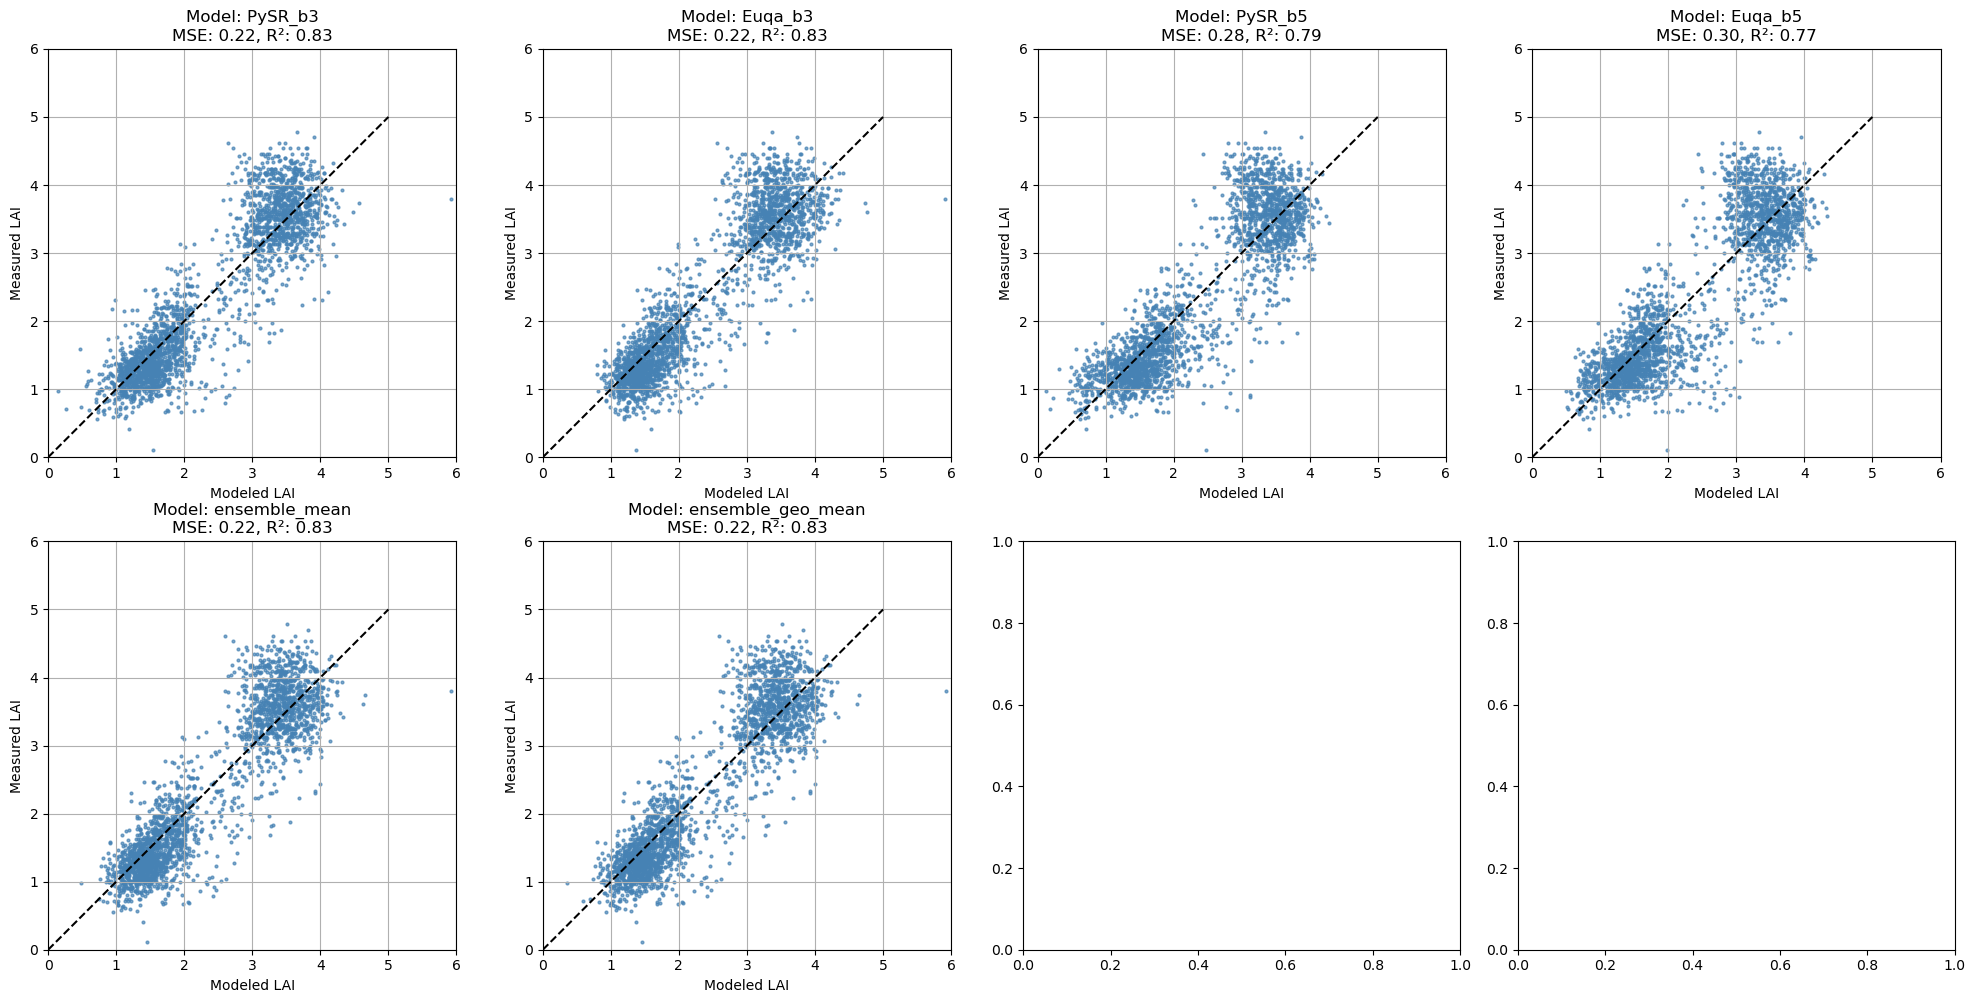

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
# Setting plottin parameters
# Number of plots based on columns in X df
Num_eqs = X.shape[1]

# # Setting the plot grid (subplot) dimensions
Number_cols = 4
Number_rows = int(np.ceil(Num_eqs / Number_cols))

# Creating a grid of subplots 
fig, axes = plt.subplots(Number_rows, Number_cols, figsize=(20, 10))


# Loop through each subplot and each equation index
for ax, column in zip(axes.flatten(), X.columns): # 

    # -----------------------------
    # 1. Compute predictions
    # -----------------------------
    y_modeled = X[column]
    y_measured = y                               # Measured LAI (y-axis)

    # -----------------------------
    # 2. Scatter plot
    # -----------------------------
    ax.scatter(
        y_modeled, 
        y_measured, s = 4, alpha = 0.7, c='steelblue',
        label="Data points"
    )

    # 1:1 reference line (perfect agreement)
    ax.plot([0, 5], [0, 5], '--k', label="1:1 line")

    # -----------------------------
    # 3. Axis formatting
    # -----------------------------
    ax.set_xlabel("Modeled LAI")
    ax.set_ylabel("Measured LAI")
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 6)
    ax.set_aspect('equal')
    # Set tick locations explicitly
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.grid(True)

    # -----------------------------
    # 4. Compute metrics
    # -----------------------------
    mse = np.mean((y_modeled - y_measured)**2)
    r2 = r2_score(y_measured, y_modeled)

    # -----------------------------
    # 5. Title with equation index + metrics
    # -----------------------------
    ax.set_title(
        f"Model: {column}\n"
        f"MSE: {mse:.2f}, R²: {r2:.2f}"
    )

# Improve spacing between subplots
plt.tight_layout()
plt.show()

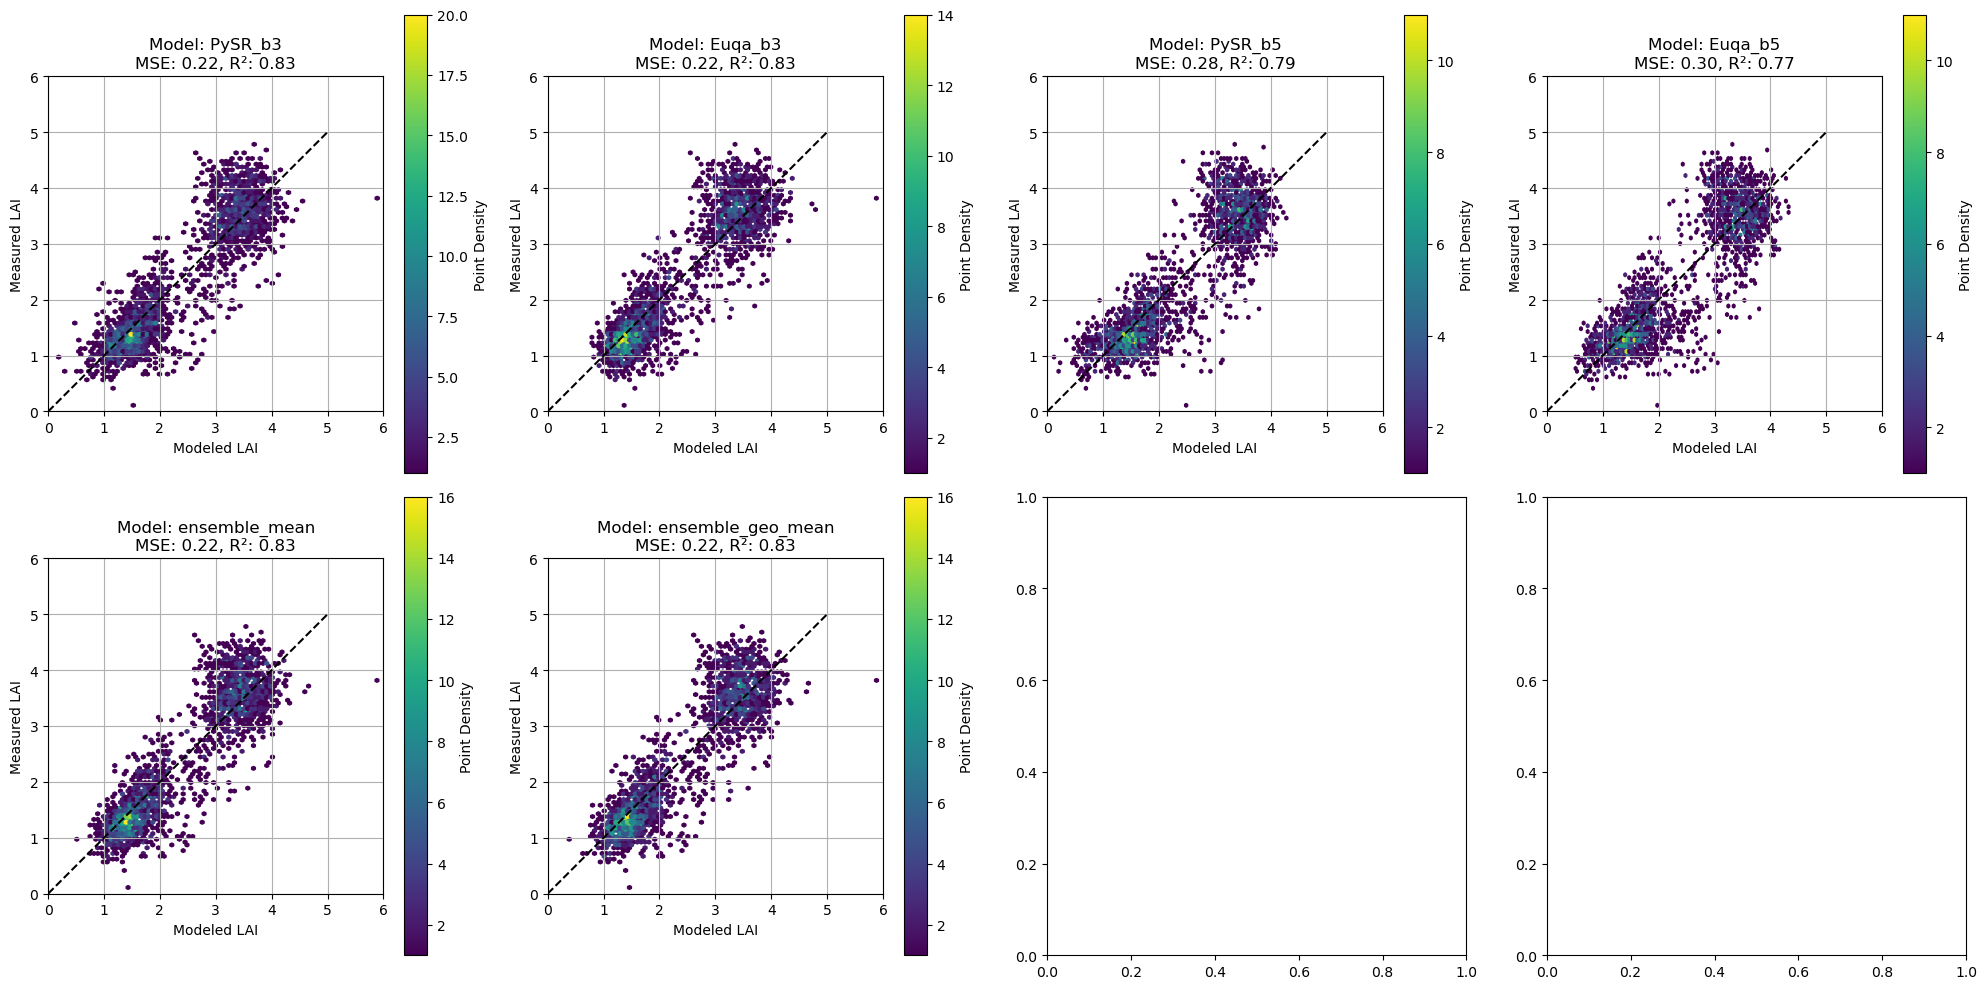

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

# Number of plots based on columns in X df
Num_eqs = X.shape[1]

# Setting the plot grid (subplot) dimensions
Number_cols = 4
Number_rows = int(np.ceil(Num_eqs / Number_cols))

# Creating a grid of subplots 
fig, axes = plt.subplots(Number_rows, Number_cols, figsize=(20, 10))

for ax, column in zip(axes.flatten(), X.columns):

    # 1. Compute predictions
    y_modeled = X[column]
    y_measured = y

    # 2. Scatter density plot (hexbin)
    hb = ax.hexbin(
        y_modeled, 
        y_measured, 
        gridsize=80, 
        cmap='viridis', 
        mincnt=1
    )
    fig.colorbar(hb, ax=ax, label='Point Density')

    # 1:1 reference line
    ax.plot([0, 5], [0, 5], '--k')

    # 3. Axis formatting
    ax.set_xlabel("Modeled LAI")
    ax.set_ylabel("Measured LAI")
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 6)
    ax.set_aspect('equal')
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.grid(True)

    # 4. Compute metrics
    mse = np.mean((y_modeled - y_measured)**2)
    r2 = r2_score(y_measured, y_modeled)

    # 5. Title
    ax.set_title(
        f"Model: {column}\n"
        f"MSE: {mse:.2f}, R²: {r2:.2f}"
    )

plt.tight_layout()
plt.show()

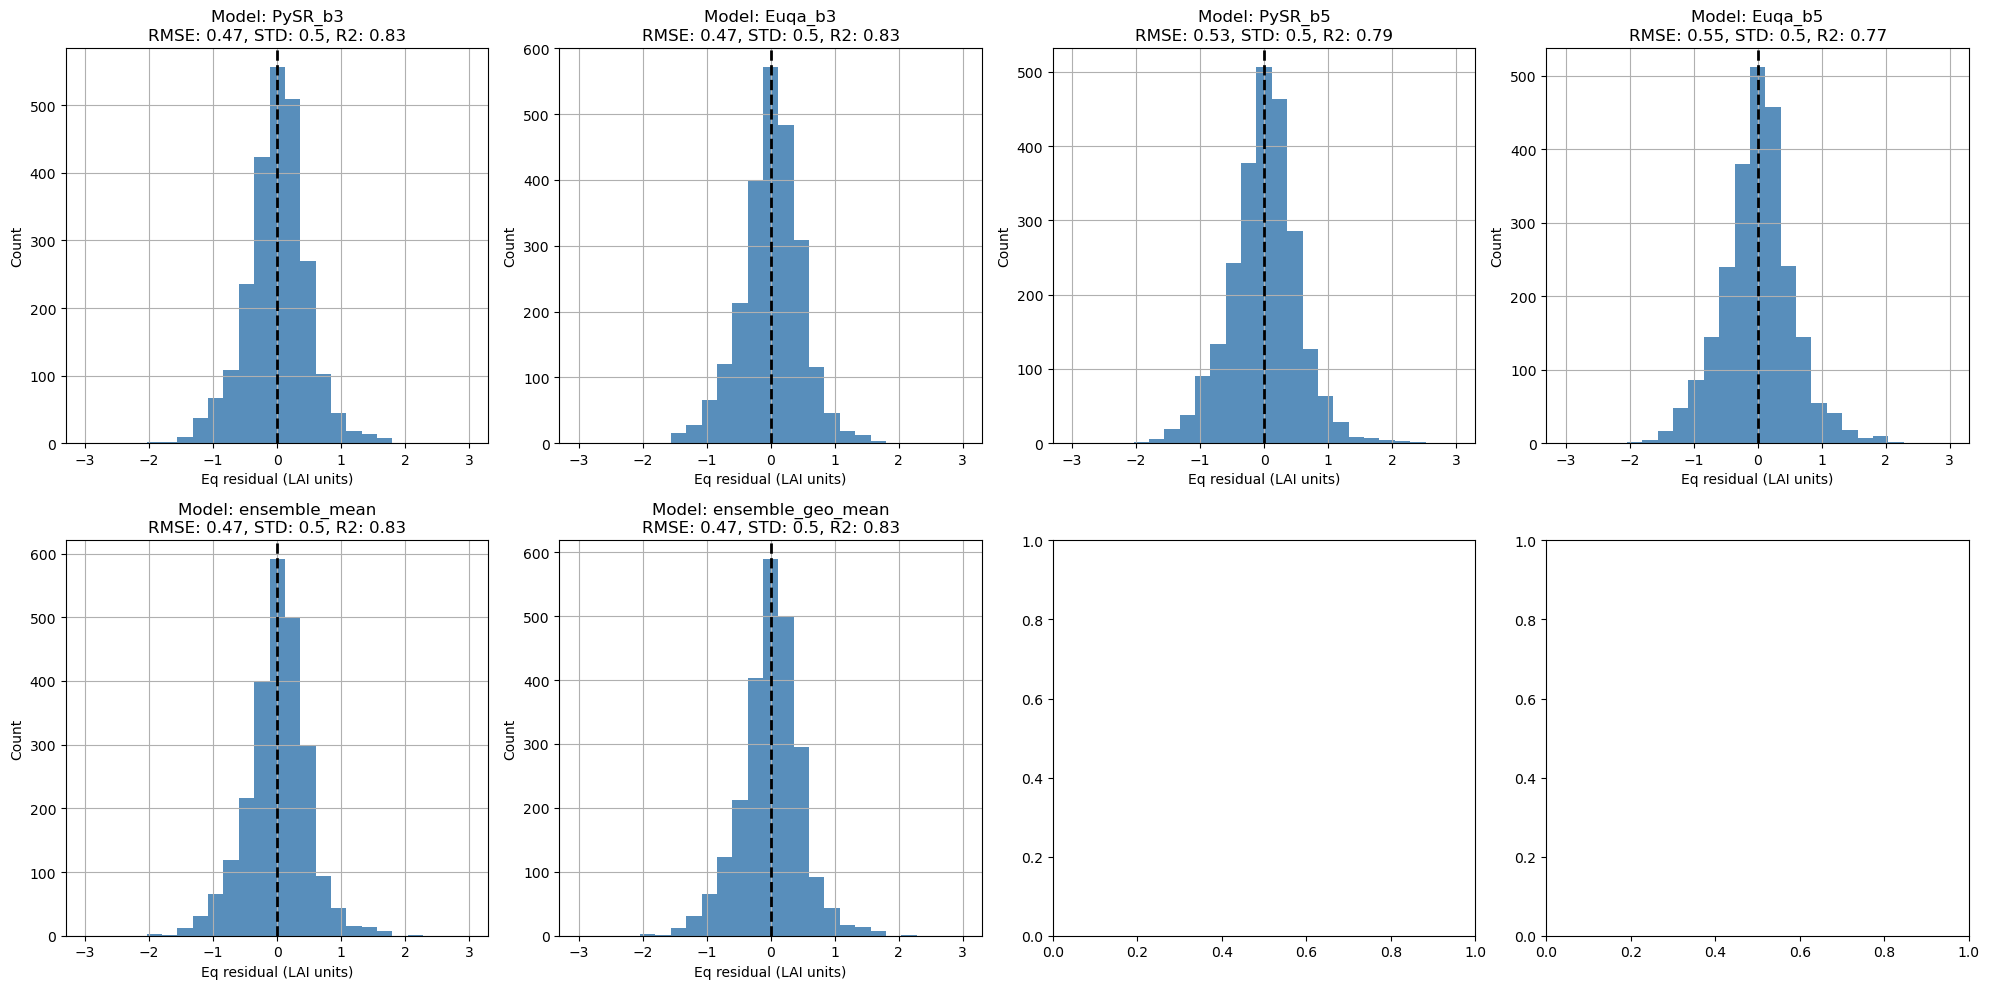

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

# ------------------------------------------------------------
# 1. Determine subplot layout based on number of models (columns in X)
# ------------------------------------------------------------
Num_eqs = X.shape[1]          # Number of equations/models to evaluate
Number_cols = 4               # Number of columns in the subplot grid
Number_rows = int(np.ceil(Num_eqs / Number_cols))  # Rows needed

# Create the figure and axes grid
fig, axes = plt.subplots(Number_rows, Number_cols, figsize=(20, 10))

# ------------------------------------------------------------
# 2. Loop through each model and create a residual histogram
# ------------------------------------------------------------
for ax, column in zip(axes.flatten(), X.columns):

    # --------------------------------------------------------
    # Extract predicted values for this model
    # --------------------------------------------------------
    ypredict_simpler = X[column]

    # Compute residuals (prediction error)
    residuals = ypredict_simpler - y

    # --------------------------------------------------------
    # 3. Plot histogram of residuals
    # --------------------------------------------------------
    ax.hist(
        residuals,
        range=(-3, 3),          # Fixed range for consistent comparison
        bins=25,                # Number of histogram bins
        color='steelblue',
        alpha=0.9
    )

    # Add a vertical line at zero (perfect prediction)
    ax.axvline(0, color='k', linestyle='--', linewidth=2)

    # Label axes
    ax.set_xlabel("Eq residual (LAI units)")
    ax.set_ylabel("Count")

    # --------------------------------------------------------
    # 4. Compute performance metrics
    # --------------------------------------------------------
    # RMSE (Root Mean Square Error):
    #   - Measures the average magnitude of prediction error
    #   - Units: same as the original variable (LAI units)
    rmse = np.sqrt(np.mean(residuals**2))

    # STD (Standard Deviation of Residuals):
    #   - Measures how spread out the residuals are around their mean
    #   - Units: same as the original variable (LAI units)
    std = np.std(residuals)

    # R² (Coefficient of Determination):
    #   - Measures how well the model explains variance in the data
    #   - Units: none (dimensionless)
    r2 = r2_score(y, ypredict_simpler)  

    # --------------------------------------------------------
    # 5. Add title with metrics
    # --------------------------------------------------------
    ax.set_title(
        f"Model: {column}\n"
        f"RMSE: {rmse:.2f}, STD: {std:.1f}, R2: {r2:.2f}"
    )

    # Add grid for readability
    ax.grid(True)

# ------------------------------------------------------------
# 6. Adjust layout to avoid overlapping labels
# ------------------------------------------------------------
plt.tight_layout()
plt.show()